- fhs_flashsale_product: (Thông tin flashsale của product)
    * period_id : id của flashsale
    * product_id : id của product 
    * original_price : giá gốc
    * flashsale_price : giá sale
    * total_items : số lượng sale
    
- fhs_flashsale_period: (Chứa thông tin flashsale về thời gian)
    * id: id của flashsale (== period_id của fhs_flashsale_product)
    * start_date, end_date: time bắt đầu kết thúc sale 
    * các cột khác không quan tâm
    
- fhs_catalog_product_entity: (Thông tin discount và ngày bắt đầu bán)
    * entity_id: id của product (==product_id trong fhs_flashsale_product)
    * sku : là mã sản phẩm (duy nhất và là khóa của sản phẩm dùng để truy các thông tin khác về sản phẩm)
    * created_at : ngày bắt đầu bán
    * discount_percent : phần trăm giảm giá so với giá bìa (trừ flashsale còn giá sản phẩm mọi lúc sẽ là giá gốc trừ đi disount này)

- fhs_cataloginventory_stock_item: Bãng này là số lượng sản phẩm tồn nhưng ko dùng được, do bên db bị mất dữ liệu
    
- fhs_sales_flat_order: Chứa thông tin đơn hàng
    * entity_id : id của đơn hàng (==order_id trong fhs_sales_flat_order_item)
    * state : trạng thái đơn hàng
    * status : trạng thái của trạng thái đơn hàng (ví dụ đơn hàng ở state đang giao, status là complete nghĩa là ở trang thái đang * giao đã hoàn thành)
    * created_at : ngày tạo đơn
    * updated_at : ngày cập nhật trạng thái
    * store_id : id của kho, id < 4 cho thương mại điện tử  (nhớ thêm điều kiện store_id<4 khi query bảng này)

- fhs_sales_flat_order_item: Chưa thông tin từng sản phẩm trong đơn hàng
    * order_id: id của đơn hàng (==entity_id trong fhs_sales_flat_order)
    * created_at: Ngày tạo đơn con
    * product_id, sku : id và mã sản phẩm

- fhs_catalog_product_entity_decimal: Bảng giá sản phẩm
    * entity_id: id của product (==entity_id trong fhs_catalog_product_entity)
    * attribute_id : loại giá (giá gốc 75, giá bán 76 (hoặc ngược lại chị không nhớ, chỉ quan tâm 2 loại này))
    * value : giá bán của sản phẩm với attribute tương ứng
    
- fhs_product_stock_log: Bảng này là thông tin các sản phẩm đang bán hiện tại trên thị trường
    * product_id, sku : id và mã của sp
    * qty: số lượng trong kho
    * is_in_stock: 1 là còn bán
    * created_at: không rõ
    * bảng này cũng không đáng tin lắm 
    
- product_dim : Thông tin sp
    * sku: mã
    * name: tên
    * cat1 tới cat5: là categories của sp
    * price : giá gốc

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

- Đọc các file csv vào các biến tương ứng

In [3]:
fhs_flashsale_product = pd.read_csv('../Data/Data_Fahasa/fhs_flashsale_product.csv')
fhs_flashsale_period = pd.read_csv('../Data/Data_Fahasa/fhs_flashsale_period.csv')
fhs_catalog_product_entity = pd.read_csv('../Data/Data_Fahasa/fhs_catalog_product_entity.csv')
fhs_sales_flat_order = pd.read_csv('../Data/Data_Fahasa/fhs_sales_flat_order.csv')
fhs_sales_flat_order_item = pd.read_csv('../Data/Data_Fahasa/fhs_sales_flat_order_item.csv')
fhs_catalog_product_entity_decimal = pd.read_csv('../Data/Data_Fahasa/fhs_catalog_product_entity_decimal.csv')
fhs_product_stock_log = pd.read_csv('../Data/Data_Fahasa/fhs_product_stock_log.csv')
product_dim = pd.read_csv('../Data/Data_Fahasa/product_dim.csv')

- Đổi tên các cột theo tên của từng file cho dễ nhận dạng

In [4]:
def rename_columns(dataframe, dataframe_name):
    """
    rename columns with patern: dataframe_name.columns_name
    Input:
        dataframe: Dataframe Pandas
        dataframe_name: string
    """
    columns = dataframe.columns
    # rename columns
    new_names = []
    for index in range(len(columns)):
        new_name = f'{dataframe_name}.{columns[index]}'
        new_names.append(new_name)
    
    dataframe.columns = new_names

rename_columns(fhs_flashsale_product, 'fhs_flashsale_product')
rename_columns(fhs_flashsale_period, 'fhs_flashsale_period')
rename_columns(fhs_catalog_product_entity, 'fhs_catalog_product_entity')
rename_columns(fhs_sales_flat_order, 'fhs_sales_flat_order')
rename_columns(fhs_sales_flat_order_item, 'fhs_sales_flat_order_item')
rename_columns(fhs_catalog_product_entity_decimal, 'fhs_catalog_product_entity_decimal')
rename_columns(fhs_product_stock_log, 'fhs_product_stock_log')
rename_columns(product_dim, 'product_dim')

- Xóa các cột không cần thiết của fhs_flashsale_period

In [5]:
temp = fhs_flashsale_period.loc[:,
    ['fhs_flashsale_period.id', 'fhs_flashsale_period.start_date', 'fhs_flashsale_period.end_date']]
# xóa đi để tiết kiệm bộ nhớ
del fhs_flashsale_period
fhs_flashsale_period = temp

- Chuyển các chuỗi thời gian về định dạng datetime

In [6]:
def string_to_datetime(dataframe, column_name):
          dataframe[f'{column_name}'] \
          = pd.to_datetime(dataframe[f'{column_name}'],
                              format = '%Y/%m/%d %H:%M:%S')

string_to_datetime(fhs_flashsale_period, 'fhs_flashsale_period.start_date')
string_to_datetime(fhs_flashsale_period, 'fhs_flashsale_period.end_date')
string_to_datetime(fhs_catalog_product_entity, 'fhs_catalog_product_entity.created_at')
string_to_datetime(fhs_sales_flat_order, 'fhs_sales_flat_order.created_at')
string_to_datetime(fhs_sales_flat_order, 'fhs_sales_flat_order.updated_at')
string_to_datetime(fhs_sales_flat_order_item, 'fhs_sales_flat_order_item.created_at')
string_to_datetime(fhs_product_stock_log, 'fhs_product_stock_log.created_at')

In [7]:
print('fhs_flashsale_product', len(fhs_flashsale_product))
print('fhs_flashsale_period', len(fhs_flashsale_period))
print('fhs_product_stock_log',len(fhs_product_stock_log))
print('fhs_catalog_product_entity',len(fhs_catalog_product_entity))
print('fhs_catalog_product_entity_decimal',len(fhs_catalog_product_entity_decimal))
print('fhs_sales_flat_order',len(fhs_sales_flat_order))
print('fhs_sales_flat_order_item',len(fhs_sales_flat_order_item))
print('product_dim',len(product_dim))

fhs_flashsale_product 3930772
fhs_flashsale_period 6416
fhs_product_stock_log 10251317
fhs_catalog_product_entity 352880
fhs_catalog_product_entity_decimal 1213003
fhs_sales_flat_order 3541823
fhs_sales_flat_order_item 17828291
product_dim 2961504


- Merge thông tin của các sản phẩm flashsale lại với nhau để lấy các thông tin cần thiết như: ()
  * Mã sku
  * Thời gian flashsale của từng sản phẩm
  * ......

In [8]:
temp = pd.merge(fhs_flashsale_product, fhs_flashsale_period, 
          left_on='fhs_flashsale_product.period_id', right_on='fhs_flashsale_period.id')
fhs_flashsale_product_info = pd.merge(temp, fhs_catalog_product_entity, 
          left_on='fhs_flashsale_product.product_id', right_on='fhs_catalog_product_entity.entity_id')
del temp
fhs_flashsale_product_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3930772 entries, 0 to 3930771
Data columns (total 12 columns):
 #   Column                                       Dtype         
---  ------                                       -----         
 0   fhs_flashsale_product.period_id              int64         
 1   fhs_flashsale_product.product_id             int64         
 2   fhs_flashsale_product.original_price         float64       
 3   fhs_flashsale_product.flashsale_price        float64       
 4   fhs_flashsale_product.total_items            float64       
 5   fhs_flashsale_period.id                      int64         
 6   fhs_flashsale_period.start_date              datetime64[ns]
 7   fhs_flashsale_period.end_date                datetime64[ns]
 8   fhs_catalog_product_entity.entity_id         int64         
 9   fhs_catalog_product_entity.sku               object        
 10  fhs_catalog_product_entity.created_at        datetime64[ns]
 11  fhs_catalog_product_entity.discount_p

- Tương tự với đơn hàng, ta sẽ merge giữa đơn hàng chính và đơn hàng con để tập trung vào các thuộc tính:
  * Trạng thái đơn hàng chính
  * Ngày tạo đơn hàng con

In [9]:
fhs_sales_flat_order_item_state  \
        = pd.merge(fhs_sales_flat_order, fhs_sales_flat_order_item,
                        left_on = 'fhs_sales_flat_order.entity_id', 
                        right_on = 'fhs_sales_flat_order_item.order_id')

fhs_sales_flat_order_item_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13969403 entries, 0 to 13969402
Data columns (total 12 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   fhs_sales_flat_order.entity_id        int64         
 1   fhs_sales_flat_order.increment_id     float64       
 2   fhs_sales_flat_order.state            object        
 3   fhs_sales_flat_order.status           object        
 4   fhs_sales_flat_order.created_at       datetime64[ns]
 5   fhs_sales_flat_order.updated_at       datetime64[ns]
 6   fhs_sales_flat_order.store_id         int64         
 7   fhs_sales_flat_order_item.item_id     int64         
 8   fhs_sales_flat_order_item.order_id    int64         
 9   fhs_sales_flat_order_item.created_at  datetime64[ns]
 10  fhs_sales_flat_order_item.product_id  float64       
 11  fhs_sales_flat_order_item.sku         object        
dtypes: datetime64[ns](3), float64(2), int64(4), object(3)
memory usage: 

- Vì số lượng dòng quá lớn nên ta sẽ thực hiện chiến lược tách các sản phẩm theo từng nhóm:
  * Theo năm: và mỗi năm chỉ lấy ra những sản phẩm bán chạy nhất hoặc lấy những sản phẩm trung bình
  * Có thể nghĩ đến chiến thuật lấy ngẫu nhiên sau đó dùng thống kê mô tả để dự đoán ảnh hưởng của flashsale đến lưu lượng bán hàng

In [10]:
# Giả sử xét trong năm 2022
import datetime 
min_year = pd.to_datetime('2022/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2022/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')

condition2 = np.where((fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] >=  min_year)
          &           (fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] <=  max_year))     
fhs_sales_flat_order_item_state_2022 = fhs_sales_flat_order_item_state.loc[condition2] 

# Tương ứng với những sản phẩm được tung ra trong khoảng thời gian này 2022
condition3 = np.where((fhs_flashsale_product_info['fhs_flashsale_period.start_date'] >=  min_year)
          &           (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] <=  max_year))
fhs_flashsale_product_info_2022 = fhs_flashsale_product_info.loc[condition3] 

In [11]:
# fhs_sales_flat_order_item_state_2022 = pd.read_csv('Data/fhs_sales_flat_order_item_state_2022.csv')
# fhs_flashsale_product_info_2022 = pd.read_csv('Data/fhs_flashsale_product_info_2022.csv')

In [12]:
print(len(fhs_sales_flat_order_item_state_2022))
print(len(fhs_flashsale_product_info_2022))

997797
797530


- Tạo thêm 4 cột giá trị, để có sau này truy vấn đơn giản hơn cho fhs_sales_flat_order_item_state:
  * flashsale_product: Có phải là đơn hàng flashsale hay không
  * flashsale_day: True là trong ngày có flashsale, False ngược lại
  * flashsale_time: True là trong khung giờ có flashsale, False ngược lại
  * flashsale_time_product: True thời gian này sản phẩm đó được flashsale, False ngược lại


- Đầu tiên là xác định có phải đơn hàng flashsale hay không

In [13]:
fhs_sales_flat_order_item_state_2022['flashsale_product'] = fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.sku']\
          .isin(fhs_flashsale_product_info_2022['fhs_catalog_product_entity.sku'])


- Tiếp theo là xem có ở trong ngày flashsale hay không

In [14]:
len(fhs_sales_flat_order_item_state_2022)

997797

In [15]:
# fhs_flashsale_product_info_2022.drop(['Unnamed: 0'], axis = 1, inplace=True)

- Xem xét sản phẩm đó có bán trong ngày flashsale hay không

In [16]:
dayofyear_flashsale = set(fhs_flashsale_product_info_2022\
          .groupby(fhs_flashsale_product_info_2022['fhs_flashsale_period.start_date'].dt.dayofyear).keys)

In [17]:
fhs_sales_flat_order_item_state_2022['flashsale_day'] = \
          np.where(fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.dayofyear.isin(dayofyear_flashsale)
                    , True, False)

- Xem xét sản phẩm có bán trong khung giờ có flash sale hay không

In [18]:
# Đầu tiên cho những thuộc tính flashsale_time bằng false hết sau đó ta sẽ gán True vào những dòng cần thiết
fhs_sales_flat_order_item_state_2022['flashsale_time'] = False

In [19]:
# Lấy các ngày sale có trong flash sale
start_end = fhs_flashsale_product_info_2022.groupby(
                    [fhs_flashsale_product_info_2022['fhs_flashsale_period.start_date'],
                    fhs_flashsale_product_info_2022['fhs_flashsale_period.end_date']])['fhs_flashsale_product.period_id'].count()
                    

In [20]:
# tạo ra dataframe để merge lại r so sánh
start_end_df = pd.DataFrame(
          {'start': start_end.index.get_level_values(0),
           'end': start_end.index.get_level_values(1)})

# merge các cột có cùng ngày với nhau
temp = \
          pd.merge(fhs_sales_flat_order_item_state_2022, start_end_df,
                    left_on = fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.dayofyear
                    ,right_on = start_end_df['start'].dt.dayofyear)

# lọc đi các dòng không thuộc thời gian flashsale
temp = temp.loc[(temp['fhs_sales_flat_order_item.created_at'] \
                    > temp['start'])
&         (temp['fhs_sales_flat_order_item.created_at'] \
                    < temp['end'])]
          
# drop đi duplicate ở mỗi đơn hàng
temp.drop_duplicates(subset = fhs_sales_flat_order_item_state_2022.columns, inplace = True)

# Cắt cột
fhs_sales_flat_order_item_flashsale_time_2022 =\
           temp.loc[:, fhs_sales_flat_order_item_state_2022.columns]

#  Xử lí để gán vào cho flashsale_time
keys = list(fhs_sales_flat_order_item_state_2022.columns)
i1 = fhs_sales_flat_order_item_state_2022.set_index(keys).index
i2 = fhs_sales_flat_order_item_flashsale_time_2022.set_index(keys).index


fhs_sales_flat_order_item_state_2022['flashsale_time'] = \
          np.where(i1.isin(i2),
          True, False)


- Xet thử sản phẩm trong giờ đó có flashsale hay không

In [21]:
# Đầu tiên cho những thuộc tính flashsale_time_product bằng false hết sau đó ta sẽ gán True vào những dòng cần thiết
fhs_sales_flat_order_item_state_2022['flashsale_time_product'] = False

In [22]:
temp = \
          pd.merge(fhs_sales_flat_order_item_state_2022, fhs_flashsale_product_info_2022,
                    left_on = 'fhs_sales_flat_order_item.sku'
                    ,right_on = 'fhs_catalog_product_entity.sku')

# Lấy các dòng sao cho lọt vào thời điểm flashsale
temp = temp.loc[
          (temp['fhs_sales_flat_order_item.created_at'] \
                    > temp['fhs_flashsale_period.start_date'])
&         (temp['fhs_sales_flat_order_item.created_at'] \
                    < temp['fhs_flashsale_period.end_date'])]

# drop đi duplicate ở mỗi đơn hàng
temp.drop_duplicates(subset = fhs_sales_flat_order_item_state_2022.columns, inplace = True)

# Cắt cột
fhs_sales_flat_order_item_flashsale_time_product_2022 =\
           temp.loc[:, fhs_sales_flat_order_item_state_2022.columns]

#  Xử lí để gán vào cho flashsale_time
keys = list(fhs_sales_flat_order_item_state_2022.columns)
i1 = fhs_sales_flat_order_item_state_2022.set_index(keys).index
i2 = fhs_sales_flat_order_item_flashsale_time_product_2022.set_index(keys).index


fhs_sales_flat_order_item_state_2022['flashsale_time_product'] = \
          np.where(i1.isin(i2),
          True, False)


In [23]:
a = fhs_sales_flat_order_item_state_2022.loc[
          (fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.state'] == 'complete')
&         (fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.status'] == 'complete')]

In [24]:
a.groupby(['flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product']).count()

fhs_sales_flat_order.entity_id  \
flashsale_product flashsale_day flashsale_time flashsale_time_product                                   
False             False         False          False                                            60536   
                  True          False          False                                            59056   
                                True           False                                           224315   
True              False         False          False                                            45902   
                  True          False          False                                            57176   
                                True           False                                           234309   
                                               True                                             39106   

                                                                       fhs_sales_flat_order.increment_id  \
flashsale_product flashsale_day flashsale_time flashsale_time_product                                      
False             False         False          False                                               60536   
                  True          False          False                                               59056   
                                True           False                                              224315   
True              False         False          False                                               45902   
                  True          False          False                                               57176   
                                True           False                                              234309   
                                               True                                                39106   

                                                                       fhs_sales_flat_order.state  \
flashsale_product flashsale_day flashsale_time flashsale_time_product                               
False             False         False          False                                        60536   
                  True          False          False                                        59056   
                                True           False                                       224315   
True              False         False          False                                        45902   
                  True          False          False                                        57176   
                                True           False                                       234309   
                                               True                                         39106   

                                                                       fhs_sales_flat_order.status  \
flashsale_product flashsale_day flashsale_time flashsale_time_product                                
False             False         False          False                                         60536   
                  True          False          False                                         59056   
                                True           False                                        224315   
True              False         False          False                                         45902   
                  True          False          False                                         57176   
                                True           False                                        234309   
                                               True                                          39106   

                                                                       fhs_sales_flat_order.created_at  \
flashsale_product flashsale_day flashsale_time flashsale_time_product                                    
False             False         False          False                                             60536   
     

- Ta show ra các tính trạng các đơn hàng

In [25]:
fhs_sales_flat_order_item_state_2022  \
          .groupby(['fhs_sales_flat_order.state'])['fhs_sales_flat_order.entity_id'].count()


fhs_sales_flat_order.state
canceled      246573
complete      720400
completed         12
new              692
processing     30120
Name: fhs_sales_flat_order.entity_id, dtype: int64

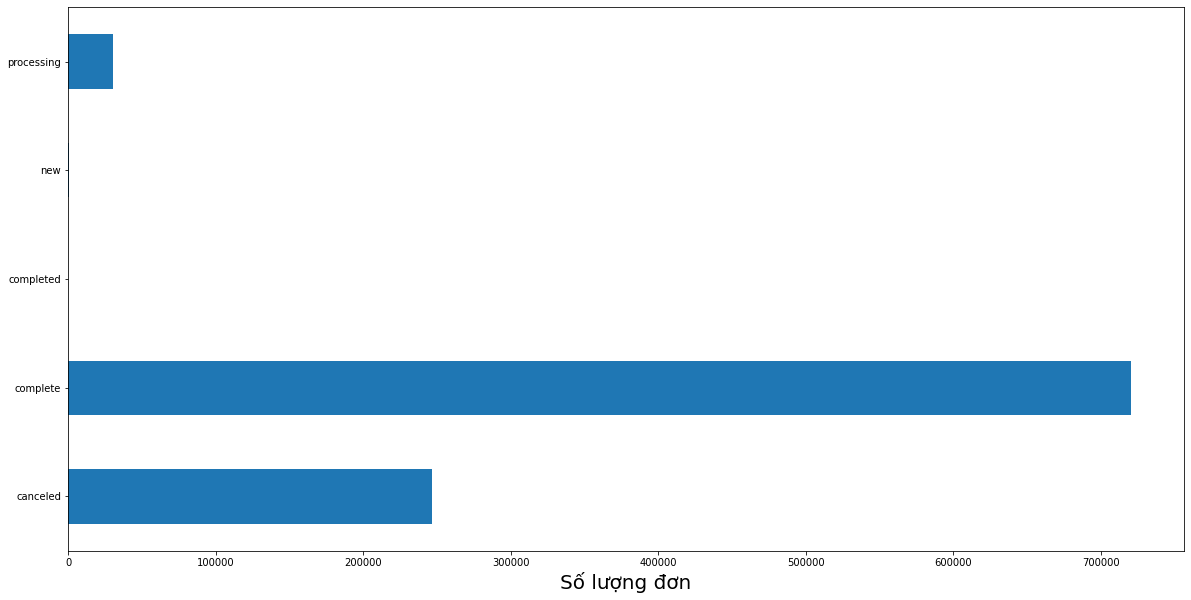

In [26]:
df = fhs_sales_flat_order_item_state_2022  \
          .groupby(['fhs_sales_flat_order.state'])['fhs_sales_flat_order.entity_id'].count()

ax = df.plot.barh(figsize = (20, 10))
ax.set_ylabel('')
ax.set_xlabel('Số lượng đơn')
ax.xaxis.label.set_fontsize(20)

- Ta tập trung xử lí vào đơn complete và canceled

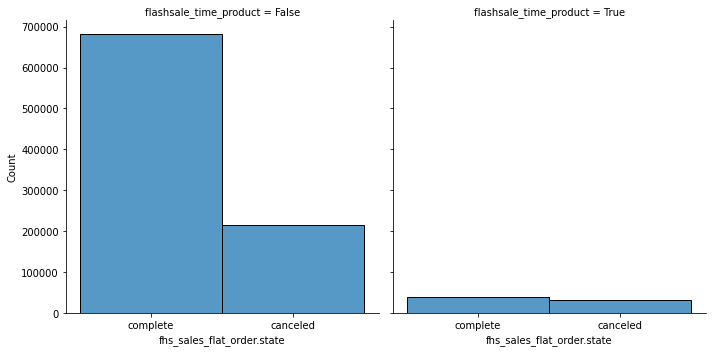

In [27]:
fhs_sales_flat_order_item_state_2022 = \
          fhs_sales_flat_order_item_state_2022\
                    .loc[(fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.state'].isin(['complete', 'canceled']))
                    &    (fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.status'].isin(['complete', 'canceled']))]

df = fhs_sales_flat_order_item_state_2022  \
          .groupby(['fhs_sales_flat_order.state', 'flashsale_time_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

sns.displot(data = fhs_sales_flat_order_item_state_2022, 
          x = 'fhs_sales_flat_order.state', col = 'flashsale_time_product')

<AxesSubplot:xlabel='fhs_sales_flat_order_item.created_at', ylabel='Count'>

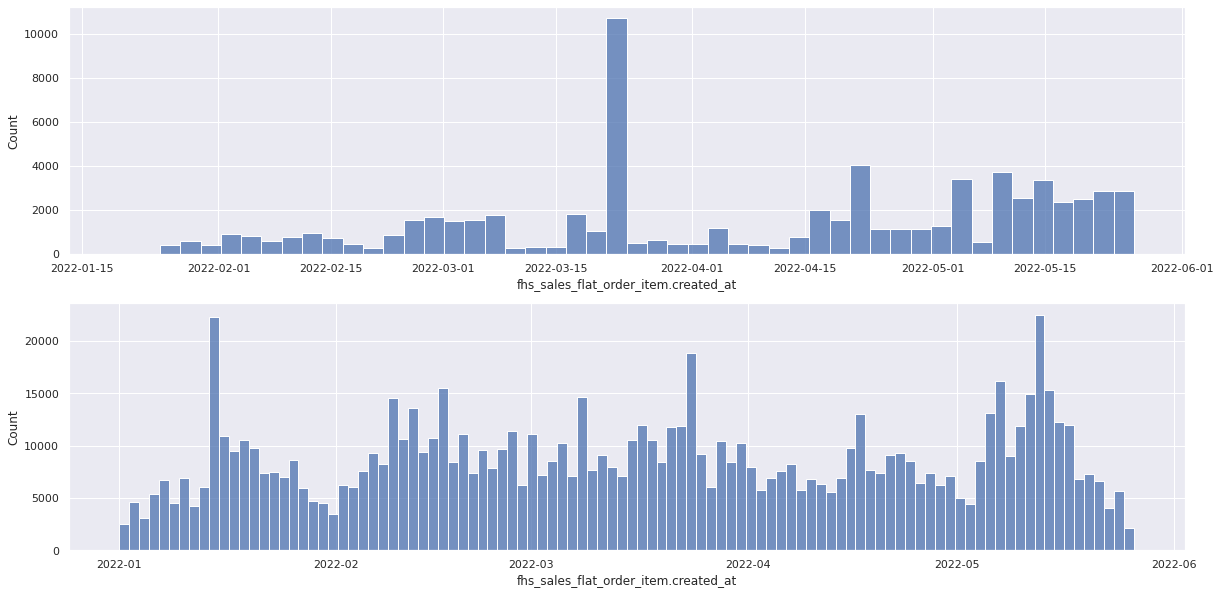

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(20,10))
sns.histplot(data = fhs_sales_flat_order_item_state_2022
                              .loc[fhs_sales_flat_order_item_state_2022['flashsale_time_product'] == True], 
          x = 'fhs_sales_flat_order_item.created_at', ax = ax[0])
sns.histplot(data = fhs_sales_flat_order_item_state_2022
                              .loc[fhs_sales_flat_order_item_state_2022['flashsale_time_product'] == False], 
          x = 'fhs_sales_flat_order_item.created_at', ax = ax[1])

- Khác period id trong flash sale nhưng vẫn cùng ngày 
- Có thể lược bỏ, tuy nhiên có thể dẫn đến sai sót khi tính số lượng bán hàng chia cho total item

- Temp là sản phẩm flashsale = True, sản phẩm bán trong ngày flashsale_day = True, sản phẩm được bán trong flashsale_time = True

### cùng một sku, xem tần suất sale check những sản phẩm có tần suất sale lớn, xem sức bán có ổn định hay không

https://stackoverflow.com/questions/43954182/unable-to-align-bins-in-a-histogram-of-datetime-objects-using-the-hist-functio